# FlyHomes Data Challenge: Kaggle Zillow Prize
### Brian Henn - September 2018 

### Key findings:

-  A gradient boosted trees (GBT) approach is used to predict error in the Zillow estimate for home prices in Southern California
- The model is based on a robust subset of the available features for each property that don't contain duplicate or missing data 
- The model is able to predict ~1% of the residual error in home prices in the Zestimate (for reference, Zillow Kaggle winners predicted about 8% of the residual error)
- The most predictive features of Zestimate error are the tax assessed value of the home and its square footage 
- There is limited predictive signal of error (at least using this first-cut GBT approach) in these core features; further improvement might be gained by including noisier (more missing data) features or through more complex models

### Notebook steps:

1. Load data from sales files and extract properties with sales in 2016 and 2017
2. Select features with robust, non-redundant data for inclusion in the model 
3. Test-train split on pooled 2016 and 2017 sales data
4. Sample hyperparameter space of GBT model via cross validation on training data, select best one
5. Train model on training data and then evaluate on test data
6. Load overall property table and predict for all, write output file

### Things to think about:

- Need a method for dealing with time explicitly, as opposed to using all 2016-2017 data for predicting sales in that period: weight sales by recency in training? 
- Need a method to incorporate the rest of the features that are mostly missing data. Simply imputing the mean is not a good choice when 90+% of the column is missing. A KNN approach would likely be a good idea to impute values in these columns, then include the in the model, and produce better predictions.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint

In [2]:
# define filename and paths
fname_features_2016 = './data/properties_2016.csv'
fname_features_2017 = './data/properties_2017.csv'
fname_sales_2016 = './data/train_2016_v2.csv'
fname_sales_2017 = './data/train_2017.csv'
fname_sub = './data/output_submission.csv'

In [41]:
# load 2016 and 2017 sales data
sales_2016 = pd.read_csv(fname_sales_2016, index_col=0, header=0, 
                         parse_dates=[2], infer_datetime_format=True)
sales_2017 = pd.read_csv(fname_sales_2017, index_col=0, header=0, 
                         parse_dates=[2], infer_datetime_format=True)
sales = pd.concat([sales_2016, sales_2017])
sales_set = sales.index.unique().values
#print(sales.head(5))

In [4]:
# inner join 2016 and 2017 feature data with sales data on parcel id

# first, load 2016 feature data, grabbing only the rows with sales data for memory purposes
iter_csv = pd.read_csv(fname_features_2016, index_col=0, header=0, iterator=True, chunksize=50000)
features_2016 = pd.concat([chunk[chunk.index.isin(sales_set)] for chunk in iter_csv])

# now, join the feature data to the sales data, duplicating properties with multiple sales
features_2016_with_sales = features_2016.merge(sales, left_index=True, right_index=True)

/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (22,49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Fraction of rows with at least one missing value: 1.0000.



Text(0.5,1,'Fraction of Missing Data')

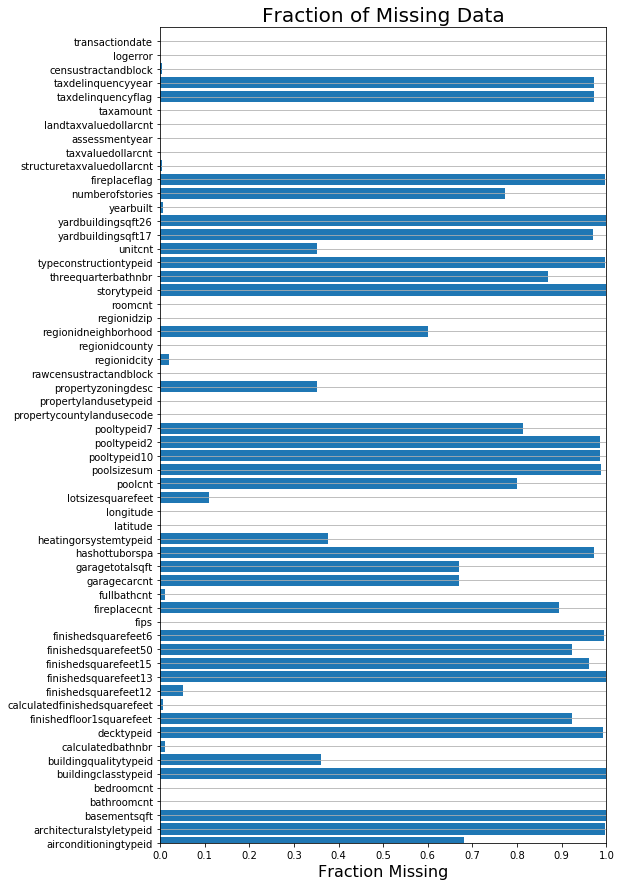

In [5]:
frac_at_least_one_missing = sum(features_2016_with_sales.isnull().sum(1) > 0)/len(features_2016_with_sales)
print('Fraction of rows with at least one missing value: %0.4f.\n' % (frac_at_least_one_missing))

frac_missing = []
for col in features_2016_with_sales.columns.values:
    frac_missing.append((len(features_2016_with_sales[col]) - features_2016_with_sales[col].count())/len(
        features_2016_with_sales[col]))
    
fig = plt.figure()
fig.set_size_inches([8,15])
ax = fig.subplots()
ax.barh(range(len(frac_missing)), frac_missing)
ax.set_xlim([0,1]) 
ax.set_xlabel('Fraction Missing', fontsize=16)
ax.set_ylim([0,len(frac_missing)])
ax.set_xticks(np.arange(0,1.01,0.1))
ax.set_yticks(range(len(frac_missing)))
ax.set_yticklabels(features_2016_with_sales.columns.values,rotation = 0);
ax.grid(True,'major','y')
ax.set_title('Fraction of Missing Data', fontsize=20)

### Takeaways from initial look at the data

- Features seem to fall into two classes: robust (non-missing) and those that are mostly missing
- Some features largely seem to duplicate each other (e.g., calculatedbathnbr vs. bathroomcnt) and so we can likely choose one
- Some categorical features are going to be critical (property type) and we need a way of dealing with them

So, let's subset to just features that do not have a lot of missing data, deal with the categoricals, and eliminate the redundant features, and go from there.

In [6]:
# reduce features to those with at least 75% of data

features_2016_with_sales = features_2016_with_sales.iloc[:,[frac < 0.25 for frac in frac_missing]]
frac_missing = [frac_missing[i] for i, _ in enumerate(frac_missing) if frac_missing[i] < 0.25]

In [7]:
#print(features_2016_with_sales.shape)
#print(features_2016_with_sales.columns)
print(features_2016_with_sales['propertylandusetypeid'].value_counts())

261.0    112994
266.0     42143
246.0      4422
269.0      4291
248.0      1594
247.0      1167
265.0       691
263.0       158
275.0       105
260.0        92
267.0        58
31.0         32
264.0        16
47.0          1
Name: propertylandusetypeid, dtype: int64


### Dealing with the categorical property type

Since distinguishing between type (single-family, condo, etc.) should be an important feature of the model, let's break 'propertylandusetypeid' into categories based on the meaning of the code:

In [8]:
# transform categorical variable about property type into more useful set of dummy variables

# single family homes (most of the dataset)
features_2016_with_sales['single_family'] = [
    1 if val == 261.0 else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# multi-family (duplex/triplex etc.)
features_2016_with_sales['multi_family'] = [
    1 if (val >= 246.0 and val <= 248.0) else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# condos (a lot of these also)
features_2016_with_sales['condominium'] = [
    1 if val == 266.0 else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# planned/cluster/mobile (a few of these)
features_2016_with_sales['planned_community'] = [
    1 if (val == 263.0 or val == 265.0 or val == 269.0) \
    else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# everything else (small number of random unusual residential types and commercial properties)
features_2016_with_sales['other_property'] = [
    1 if val not in [246.0, 247.0, 248.0, 261.0, 263.0, 265.0, 266.0, 
        269.0] else 0 for val in features_2016_with_sales['propertylandusetypeid']]

#features_2016_with_sales[['propertylandusetypeid','single_family','multi_family','condominium']].sample(15)

### Now, let's define the features we want in the model

We've gotten rid of columns with mostly missing data, dealt with categoricals, and now we can look at the data.

In [9]:
# list useful features for inclusion in the model

features_in_model = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','fullbathcnt',
                     'latitude','longitude','lotsizesquarefeet','single_family','multi_family','condominium',
                    'planned_community','other_property','regionidzip','yearbuilt','taxvaluedollarcnt']

X = features_2016_with_sales[features_in_model]
X.sample(10)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,single_family,multi_family,condominium,planned_community,other_property,regionidzip,yearbuilt,taxvaluedollarcnt
parcelid,,,,,,,,,,,,,,,
13842788,2.0,1.0,1002.0,1.0,33736382.0,-117864598.0,7500.0,1,0,0,0,0,97001.0,1922.0,206647.0
11933269,2.0,3.0,1226.0,3.0,34082100.0,-118282000.0,14999.0,0,0,1,0,0,96007.0,1990.0,509000.0
12134938,2.0,1.0,1922.0,1.0,34149866.0,-118029047.0,8281.0,1,0,0,0,0,96267.0,1937.0,1010000.0
12865774,2.0,2.0,1505.0,2.0,34109653.0,-117719071.0,5806.0,1,0,0,0,0,96469.0,1953.0,436000.0
11344414,3.0,3.0,1592.0,3.0,34473647.0,-118529858.0,4245.0,1,0,0,0,0,96403.0,1989.0,297945.0
17082998,3.0,2.0,1457.0,2.0,34274183.0,-119244379.0,16007.0,1,0,0,0,0,97083.0,1948.0,77854.0
12283597,3.0,2.0,1345.0,2.0,33917029.0,-118194724.0,6297.0,1,0,0,0,0,96113.0,1952.0,337000.0
11646043,2.0,2.0,1155.0,2.0,34068000.0,-118453000.0,16349.0,0,0,1,0,0,96005.0,1972.0,624268.0
12420607,4.0,3.0,2131.0,3.0,33852376.0,-118053568.0,4999.0,1,0,0,0,0,96206.0,1972.0,379329.0


### Impute missing data 

Since there are still missing values in these columns (<1% each), we can use a simple method (column mean) to fill them in.

Now, we have a training and test dataset ready for modeling.

In [ ]:
# impute missing values using sklearn's implementation

# impute using the mean as a simple solution
imputer = Imputer(strategy='mean')
X_imputed = X.copy()
for col in X.columns.values:
    if sum(X[col].isna()) > 0: # only apply this to columns with missing data
        imputer.fit(X[[col]])
        X_imputed[col] = imputer.transform(X[[col]]).ravel()

X_imputed.sample(20)

In [42]:
# get sales data as training dataset

Y = features_2016_with_sales[['logerror','transactiondate']]
#Y.sample(15)

### Examine feature correlations and correlations with target

We want to check for correlations bewteen our features and between the features and the target (Zestimate log error). If features are strongly colinear we maybe should not include them. And the correlations between the features and the target may give a sense of what will predict what we care about.

To do this we will make a heat map of correlations.

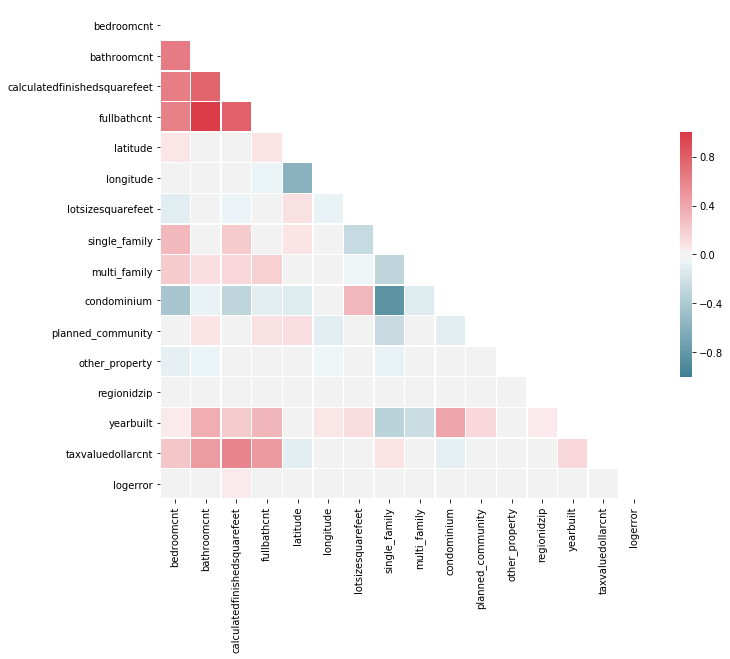

In [12]:
# examine the correlations among the selected features and with the log error

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# set up colormap for correlation plots
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmax = 1
cmin = -1

# create a dataframe of just the features we want to look at, plus the target)
plot_columns = features_in_model
plot_columns.append('logerror')
full_df = features_2016_with_sales[plot_columns]
                                                    
# Compute the correlation matrix
corr_properties = full_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_properties, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_properties, mask=mask, cmap=cmap, vmax=cmax, vmin=cmin, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

(16, 16)


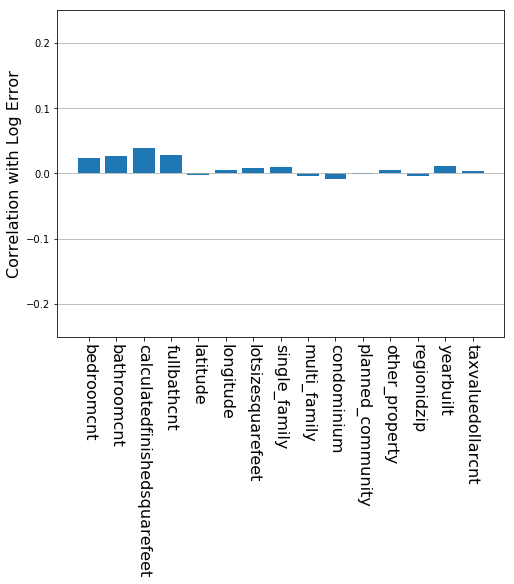

In [13]:
# now bar plot just correlation of logerror against features

print(corr_properties.shape)

fig = plt.figure()
fig.set_size_inches([8,6])
ax = fig.subplots()
ax.bar(range(len(full_df.columns.values) - 1), corr_properties.iloc[-1,0:15])
ax.set_ylim([-0.25,0.25])
ax.set_ylabel('Correlation with Log Error', fontsize=16)
ax.set_xticks(range(len(full_df.columns.values) - 1))
ax.set_xticklabels(full_df.columns.values[0:-1],rotation=-90, fontsize=16)
ax.grid(True,'major','y')

### Takeaways from correlation analysis

- The features are not strongly co-linear, which is good. The only ones that are co-linear are things like bathroom count vs. full bathroom count, or between the property categories, which is to be expected. We still might expect added information from these categories so we keep them.
- There is little correlation between the features and the log error. This is not surprising since if there were then making the Zestimate better wold be an easy problem to solve! However, this is linear correlation; it is possible that there is structure in the log error that a non-linear model like GBT can pick up on.

So, let's proceed with model training on these features!

In [ ]:
# split sample into training and test sets 
# retain 20% of the properties with sales (34k) as a test dataset, train on 80% (134k)
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y['logerror'], test_size=0.2, shuffle=True)

# Note: for the moment we are not worry about the time dimension of the sales,
# instead just using all of the sales from 2016 and 2017 as both training and validation data

### Choosing the right model: Gradient Boosting Regressor

I choose a GBT model for this problem because:

- it can handle nonlinear relationships between features and targets
- it can avoiding overfitting using an stochastic ensemble approach of boosted trees
- it has been shown to have high skill for many ML problems 
- it can produce confidence intervals on predictions directly from the ensemble approach

To make the GBT model work well, I apply the following approach:

- tuning of hyperparameters via k-fold cross validation against the training dataset
- including multiple hyperparameters (number of boosted trees, depth of trees, split metric, etc.) in the tuning
- estimating error on the test dataset using a model trained using the best hyperparameters on the training dataset

In [15]:
# let's train the gradient boosted tree model's hyperparameters using sklearn's RandomSearchCV capabilities

# define the estimator as GBT
gbt = GradientBoostingRegressor(loss='lad')

# define the hyperparameter we want to search across in random sampling (as in section 2)
param_dist = {'n_estimators' : randint(2, 100), # number of boosting iterations 
              'max_depth' : randint(3, 5), # allow for potentially many (100 splits) in the trees
              'max_features' : [None, 'sqrt'], # allow either any number of features in bagging, or just the sqrt
              'min_samples_split' : randint(2, 11), # controls on splitting and leaves
              'min_samples_leaf' : randint(1, 11),
              'criterion' : ['friedman_mse', 'mse']} # vary the scoring method
# random sampling strategy suggested by scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

# randomly search parameters using my laptop's cores
n_iter_random = 20 # 20 iterations of parameters for each fold 
cv_random = 5 # 5-fold cross validation
gbt_hypertuning = RandomizedSearchCV(estimator=gbt, param_distributions=param_dist, n_iter=n_iter_random,
                               cv=cv_random, random_state=120914, n_jobs=-1, verbose=4, return_train_score=True)

# Fit the random search model for hyperparameter tuning
gbt_hypertuning.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97 
[CV] criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97 
[CV] criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97 
[CV] criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97 
[CV]  criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97, score=0.0020284824094071174, total= 1.5min
[CV] criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97 
[CV]  criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97, score=0.0024106475403411487, total= 1.6min
[CV] criterion=ms

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.3min


[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=2, score=-0.0006972801266680317, total=   1.5s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, min_samples_split=3, n_estimators=35 
[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=2, score=-0.0015648071857161663, total=   1.4s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, min_samples_split=3, n_estimators=35 
[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, min_samples_split=3, n_estimators=35, score=-0.0004596602601187882, total=  12.9s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, min_samples_split=3, n_estimators=35 
[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, min_samples_split=3, n_estimators=35, score=8.891360863128028e-05, total=  12.3s
[CV] criterion=mse, max_depth=3, ma

[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=3, n_estimators=92 
[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=84, score=0.0018808235703613452, total=  25.8s
[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=3, n_estimators=92 
[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=84, score=0.0019483601759190394, total=  27.9s
[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=3, n_estimators=92 
[CV]  criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=3, n_estimators=92, score=0.0021855149579713684, total= 1.7min
[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=3, n_estimators=92 
[CV]  criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split

[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=55 
[CV]  criterion=mse, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=3, n_estimators=23, score=0.0011172512985517802, total=  21.2s
[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=55 
[CV]  criterion=mse, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=3, n_estimators=23, score=0.0010231622067909951, total=  21.0s
[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=55 
[CV]  criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=55, score=0.0010018766947678115, total= 1.1min
[CV] criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=2, n_estimators=55 
[CV]  criterion=mse, max_depth=4, max_features=None, min_samples_leaf=10, min_samples_split=2

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 16.4min


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=49, score=0.002293414689347073, total=  22.7s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=7, n_estimators=21 
[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=7, n_estimators=21, score=-0.0011538296894566535, total=   9.2s
[CV] criterion=mse, max_depth=3, max_features=None, min_samples_leaf=7, min_samples_split=8, n_estimators=56 
[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=7, n_estimators=21, score=0.0010570687102220422, total=   9.7s
[CV] criterion=mse, max_depth=3, max_features=None, min_samples_leaf=7, min_samples_split=8, n_estimators=56 
[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, min_samples_split=7, n_estimators=21, score=0.0008502412052023844, total=   9.9s
[CV] crit

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe18e9b2358>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe18e9b24a8>, 'max_features': [None, 'sqrt'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe18e9b2630>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe18e9b2908

In [16]:
results_df = pd.DataFrame(gbt_hypertuning.cv_results_)
results_df.sort_values('mean_test_score', ascending=False, inplace=True)
results_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,36.948208,1.554087,0.319071,0.086717,friedman_mse,4,sqrt,3,7,86,...,0.002280,0.002078,1,0.005522,0.004334,0.004557,0.005122,0.003976,0.004702,0.000553
10,105.957788,6.320785,0.253485,0.062552,mse,4,None,10,3,92,...,0.001782,0.001096,2,0.004830,0.004393,0.005439,0.004858,0.004324,0.004769,0.000400
11,28.926908,0.803978,0.242315,0.051427,friedman_mse,4,sqrt,6,4,73,...,0.001504,0.000818,3,0.004813,0.003312,0.004833,0.003336,0.002941,0.003847,0.000809
0,95.640701,3.652272,0.187319,0.035003,friedman_mse,4,None,1,6,97,...,0.001436,0.001505,4,0.005946,0.004634,0.006714,0.006619,0.005238,0.005830,0.000800
16,66.315540,2.036633,0.130601,0.018190,mse,4,None,10,2,55,...,0.001399,0.000986,5,0.003873,0.003270,0.003837,0.003094,0.003119,0.003439,0.000346


In [17]:
# train model using best hyperparameters and whole training dataset

# use the best hyperparameters
best = gbt_hypertuning.best_params_
print(best)
gbt_train = GradientBoostingRegressor(**best)

# train the model
gbt_train.fit(X_train,Y_train)

{'criterion': 'friedman_mse', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 86}


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=3, min_samples_split=7,
             min_weight_fraction_leaf=0.0, n_estimators=86, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [18]:
# evaluate best model on test dataset

# produce predictions 
Y_pred = gbt_train.predict(X_test)

# compute MAE on predictions
MAE = mean_absolute_error(Y_pred, Y_test)
print(MAE)

gbt_train.score(X_test, Y_test, sample_weight=None)

0.06972498957911655


0.014051613881057912

Text(0.5,1,'Model Evaluation Plot')

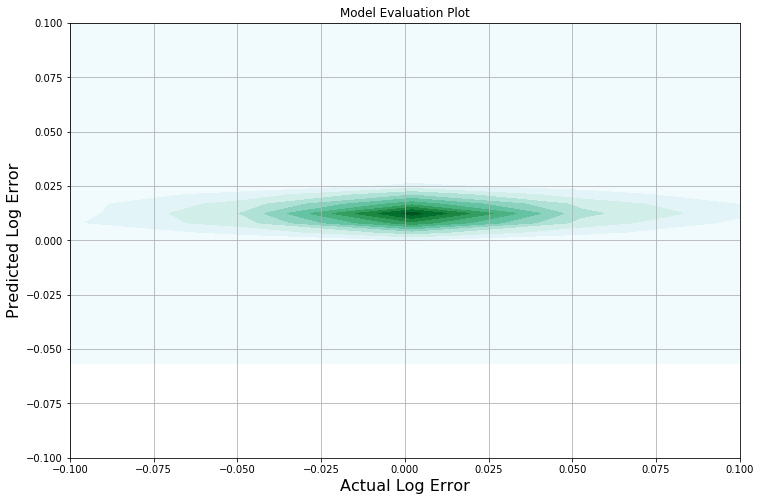

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches([12,8])
#ax.plot(Y_test, Y_pred, 'b +')
ax = sns.kdeplot(Y_test[::10], Y_pred[::10], shade=True)
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_xlabel('Actual Log Error', fontsize=16)
ax.set_ylabel('Predicted Log Error', fontsize=16)
ax.grid()
ax.set_title('Model Evaluation Plot')

### Interpretation of model training

Well, that's not great, but it's something. The tuned/trained model was able to predict about 1.4% of the variance (R^2 = 0.014) of the log error. In other words, of the residual error in the Zestimate, this model can predict about 1/70 of it. So if the current Zestimate has an error of about +/- 7% as implied by the mean absolute log error of 0.069, then an improvement such as this would reduce that by about 0.10 percentage points, say to +/- 6.9%. Better than nothing I guess!

For reference, the top of the kaggle leaderboard shows models that reduce the log error AME to about 0.064, indicating that they were able to predict perhaps 8% of the variance of the residual error. That would be more like an improvement in Zestimate error to +/- 6.4%. So while those models are better than what was produced here, they are not dramatically better. **This is a hard problem!**

Let's now examine the feature importance in the model to see what actually predicted Zestimate error.

Text(0.5,0,'Feature Name')

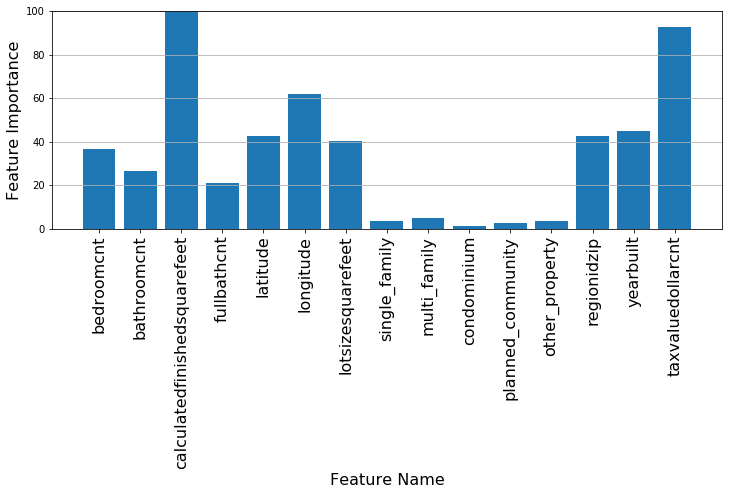

In [20]:
# now extract feature importances and plot
feature_importances = gbt_train.feature_importances_
feature_names = X_imputed.columns.values

fig = plt.figure()
fig.set_size_inches([12,4])
ax = fig.subplots(1)
ax.bar(range(1,len(feature_importances) + 1), 100*feature_importances/max(feature_importances))
ax.set_ylim([0, 100])
ax.set_xticks(range(1,len(feature_importances) + 1))
ax.set_xticklabels(feature_names,FontSize=16, rotation=90)
ax.grid(True,'major','y')
ax.set_ylabel('Feature Importance',FontSize=16)
ax.set_xlabel('Feature Name',FontSize=16)

### Feature importance interpretation

The two most important features are the tax payment and the square footage. Location, year built, and lot size show some importance also. The type of property was not predictive (intersting).

So, we can interpret that the Zestimate model (which uses price per square foot in its calculations I believe) is sensitive to errors due to this assumption. It also shows that the way that the assessed tax value/payment is used may introduce errors. Both of these features would therefore be useful starting places in improving the model.

### A note about time 

In this very preliminary approach I did not account for time explicitly, instead using the entire 2016-2017 sales data as training for the features in the 2016 dataset. This muddles the effect of time and may limit the skill of the model, i.e., all 6 of the prediction periods have the same forecast in this model. 

A logical next step would be to explicity account for the timing of recent sales in making predictions for a given time. The way to do this might be to weight the sales data by its recency to the forecast date during model training, and excludes sales data from *after* the forecast date. This obviously would have to happen in a real model implementation. 

#### The rest of the notebook deals with predicting the full (3M) property dataset and producing an output file for submission to Kaggle. FWIW, this notebook produced a middle/back of the pack solution relative to the public leaderboard. An interesting problem I would like to spend more time on :)

In [21]:
# in order to make predictions for the full dataset, first load the model columns from the 2016 data

raw_features_in_model = ['parcelid','bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','fullbathcnt',
                         'latitude','longitude','lotsizesquarefeet','propertylandusetypeid',
                         'regionidzip','yearbuilt','taxvaluedollarcnt']

features_full_2016 = pd.read_csv(fname_features_2016, index_col=0, header=0, usecols=raw_features_in_model)

/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [22]:
features_full_2016.sample(10)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,regionidzip,yearbuilt,taxvaluedollarcnt
parcelid,,,,,,,,,,,
13981101,3.0,4.0,3508.0,3.0,33633567.0,-117891221.0,10720.0,261.0,96978.0,1965.0,2217000.0
11490231,3.0,3.0,1830.0,3.0,33869700.0,-118379000.0,7493.0,266.0,96124.0,2004.0,746517.0
13943549,2.0,3.0,1749.0,2.0,33763110.0,-117980464.0,9112.0,261.0,96990.0,1959.0,450828.0
13113569,0.0,0.0,1422.0,NaN,33984100.0,-118454000.0,NaN,266.0,96128.0,NaN,367845.0
11347912,4.0,5.0,3389.0,4.0,34471635.0,-118554916.0,9408.0,261.0,96377.0,2003.0,681000.0
12613076,0.0,0.0,NaN,NaN,33790208.0,-118313609.0,9179.0,261.0,96217.0,NaN,33682.0
11491300,4.0,3.0,1452.0,4.0,33870261.0,-118368065.0,7507.0,266.0,96124.0,1999.0,637486.0
13903176,1.5,3.0,1318.0,1.0,33879462.0,-117991706.0,1666.0,261.0,96181.0,1973.0,311272.0
11938228,0.0,0.0,1424.0,NaN,34065942.0,-118237471.0,1350.0,47.0,95993.0,1947.0,68691.0


In [23]:
# repeat dealing with categorical data and imputation 

# single family homes (most of the dataset)
features_full_2016['single_family'] = [
    1 if val == 261.0 else 0 for val in features_full_2016['propertylandusetypeid']]
# multi-family (duplex/triplex etc.)
features_full_2016['multi_family'] = [
    1 if (val >= 246.0 and val <= 248.0) else 0 for val in features_full_2016['propertylandusetypeid']]
# condos (a lot of these also)
features_full_2016['condominium'] = [
    1 if val == 266.0 else 0 for val in features_full_2016['propertylandusetypeid']]
# planned/cluster/mobile (a few of these)
features_full_2016['planned_community'] = [
    1 if (val == 263.0 or val == 265.0 or val == 269.0) \
    else 0 for val in features_full_2016['propertylandusetypeid']]
# everything else (small number of random unusual residential types and commercial properties)
features_full_2016['other_property'] = [
    1 if val not in [246.0, 247.0, 248.0, 261.0, 263.0, 265.0, 266.0, 
        269.0] else 0 for val in features_full_2016['propertylandusetypeid']]

X_full = features_full_2016[features_in_model[:-1]]
#X.sample(10)
del features_full_2016

# impute using the mean as a simple solution
for col in X_full.columns.values:
    if sum(X_full[col].isna()) > 0: # only apply this to columns with missing data
        imputer.fit(X_full[[col]])
        X_full[col] = imputer.transform(X_full[[col]]).ravel()

In [24]:
# now produce predictions for the full dataset using the trained model
Y_pred_full = gbt_train.predict(X_full)

Y_pred_df = pd.DataFrame({'ParcelId': X_full.index, 'y_pred' : Y_pred_full})

In [43]:
## write output file for submission to kaggle 
#
#file = open(fname_sub, 'w')
#file.write('ParcelId,201610,201611,201612,201710,201711,201712\n')
#for i in range(len(Y_pred_df)):
##    print(Y_pred_df.ParcelId[i], Y_pred_df.y_pred.values[i])
#    file.write('%u,%4.4f,%4.4f,%4.4f,%4.4f,%4.4f,%4.4f\n' % (
#        Y_pred_df.ParcelId[i], 
#        Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i], 
#        Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i]))
#file.close()